In [4]:
import markdown
import math
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import pandas as pd
from collections import defaultdict
from timeit import Timer
from math import factorial

<h2>Question 0</h2>
<p>the url for 2009 micro data is <a href="https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public.csv">https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public.csv</a><br />
the url for 2015 micro data is <a href="https://www.eia.gov/consumption/residential/data/2015/csv/recs2015_public_v4.csv">https://www.eia.gov/consumption/residential/data/2015/csv/recs2015_public_v4.csv</a><br />
the url for 2009 replicate weights is <a href="https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public_repweights.csv">https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public_repweights.csv</a><br />
my variables contain DOEID, NWEIGHT, REGIONC, HDD65, CDD65<br />
the link of how to use replicate weight is <a href="https://www.eia.gov/consumption/residential/methodology/2009/pdf/using-microdata-022613.pdf">https://www.eia.gov/consumption/residential/methodology/2009/pdf/using-microdata-022613.pdf</a>  </p>

<p>$$\hat{V}(\hat{\theta}) = \frac{1}{R(1 - \varepsilon)^2} \sum_{r=1}^{R}(\hat{\theta}_r-\hat{\theta})^2$$<br />
$\theta$ :population parameter of interest<br />
$\hat{\theta}$ :estimate from the full sample for $\theta$<br />
$\hat{\theta}_r$ :estimate from the rth replicate subsample by using replicate weights
$\varepsilon$ : Fay coefficient, 0 &lt; $\varepsilon$ &lt; 1<br />
For the 2009 RECS, R = 244( the number of replicate subsamples) and $\varepsilon$ = 5. The formula for calculating the RSE is:
$$(\frac{\sqrt{\hat{V}(\hat{\theta})}}{\hat{\theta}}) * 100$$</p>

In [11]:
##Q1
##A
data_2009 = pd.read_csv('https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public.csv')
data_2015 = pd.read_csv('https://www.eia.gov/consumption/residential/data/2015/csv/recs2015_public_v4.csv')
data_r2009 = pd.read_csv('https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public_repweights.csv')
data_2009_clean = data_2009[['DOEID', 'NWEIGHT', 'REGIONC', 'HDD65', 'CDD65']]
data_2015_clean = data_2015[['DOEID', 'NWEIGHT', 'REGIONC', 'HDD65', 'CDD65']]
data_2009_clean[['DOEID','REGIONC']] = data_2009_clean[['DOEID','REGIONC']].astype('category')
data_2015_clean[['DOEID','REGIONC']] = data_2015_clean[['DOEID','REGIONC']].astype('category')

F:\umich\python\ana1\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (717,718) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
F:\umich\python\ana1\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [12]:
##B
data_3 = data_r2009.drop(['NWEIGHT'], axis = 1)
data_2009_long = pd.melt(data_3, id_vars = ['DOEID'], value_name='val')
data_2009_long.columns = ['DOEID', '2009_brr_weight', 'replicate_weight']
data_2009_long

,DOEID,2009_brr_weight,replicate_weight
0,1,brr_weight_1,3628.305158
1,2,brr_weight_1,4408.308000
2,3,brr_weight_1,13664.732100
3,4,brr_weight_1,9456.435434
4,5,brr_weight_1,8659.554041
...,...,...,...
2948247,12079,brr_weight_244,15669.237850
2948248,12080,brr_weight_244,3976.693639
2948249,12081,brr_weight_244,2479.082636
2948250,12082,brr_weight_244,17663.466590


In [13]:
data_4 = data_2015.filter(regex='BRRWT')
data_5 = data_2015[['DOEID']]
data_6 = pd.concat([data_4,data_5],axis=1)
for xx in range(1, 96):
    if xx < 10:
        xx = str(xx)
        xx='0' + xx
    else:
        xx = str(xx)
    a = 'BRRWT{}'.format(xx)

data_2015_long = pd.melt(data_6,id_vars=['DOEID'], value_name = 'values')
data_2015_long.columns = ['DOEID', '2015_brr_weight', 'replicate_weight']
data_2015_long


,DOEID,2015_brr_weight,replicate_weight
0,10001,BRRWT1,16555.311270
1,10002,BRRWT1,21486.287200
2,10003,BRRWT1,12297.436760
3,10004,BRRWT1,18553.958900
4,10005,BRRWT1,8075.744168
...,...,...,...
545851,15682,BRRWT96,20183.445250
545852,15683,BRRWT96,19681.916720
545853,15684,BRRWT96,29148.112150
545854,15685,BRRWT96,20695.042680


In [14]:
##Q2
##A
##2009 point estimate
data_2009_new = pd.merge(data_2009_clean, data_2009_long, on=[ 'DOEID'], how='left', indicator=True)
data_2009_new['cool'] = data_2009_new['NWEIGHT']*data_2009_new['CDD65']
data_2009_new['heat'] = data_2009_new['NWEIGHT']*data_2009_new['HDD65']
data_2009_new['value'] = data_2009_new['replicate_weight']*data_2009_new['CDD65']
data_sum1 = data_2009_new.groupby('REGIONC').sum()
data_sum1['pointestimate_cool'] = data_sum1['cool']/data_sum1['NWEIGHT']
data_sum1['pointestimate_heat'] = data_sum1['heat']/data_sum1['NWEIGHT']
data_sum1

,DOEID,NWEIGHT,HDD65,CDD65,replicate_weight,cool,heat,value,pointestimate_cool,pointestimate_heat
REGIONC,,,,,,,,,,
1,3327537800,5.067989e+09,3258887668,345947836,5.067989e+09,3.449857e+12,2.889255e+13,3.450764e+12,680.715125,5700.988131
2,4199550612,6.323875e+09,4360306108,509020844,6.323875e+09,4.179375e+12,4.000064e+13,4.178840e+12,660.888382,6325.337030
3,6056457468,1.026756e+10,2431946292,2389502736,1.026756e+10,2.266798e+13,2.768819e+13,2.265761e+13,2207.728377,2696.667536
4,4229792704,6.062938e+09,2158677760,928502472,6.062938e+09,8.055475e+12,1.976300e+13,8.051945e+12,1328.642144,3259.641431


In [35]:
##2009 ci
ci_09 = pd.merge(data_2009_clean, data_3, on = 'DOEID', how = 'left')

ci_09['cool_est'] = ci_09['NWEIGHT']*ci_09['CDD65']
ci_09['heat_est'] = ci_09['NWEIGHT']*ci_09['HDD65']

for i in range (1, 245):
    a = 'brr_weight_{}'.format(i)
    b = 'cool_{}'.format(i)
    c = 'heat_{}'.format(i)
    ci_09[b] = ci_09['CDD65']*ci_09[a]
    ci_09[c] = ci_09['HDD65']*ci_09[a]
ci_outcome = ci_09.groupby(['REGIONC']).sum()
ci_outcome['cool_sum'] = 0
ci_outcome['heat_sum'] = 0
ci_outcome['theta_cool'] = ci_outcome['cool_est']/ci_outcome['NWEIGHT']
ci_outcome['theta_heat'] = ci_outcome['heat_est']/ci_outcome['NWEIGHT']

for i in range (1, 245):
    a = 'brr_weight_{}'.format(i)
    b = 'cool_{}'.format(i)
    c = 'heat_{}'.format(i)
    d = 'theta_cool_{}'.format(i)
    e = 'theta_heat_{}'.format(i)
    ci_outcome[d] = ci_outcome[b]/ci_outcome[a]
    ci_outcome[e] = ci_outcome[c]/ci_outcome[a]
    ci_outcome['cool_sum'] = ci_outcome['cool_sum']+((ci_outcome[d]- ci_outcome['theta_cool'])**2)
    ci_outcome['heat_sum'] = ci_outcome['heat_sum']+((ci_outcome[e]- ci_outcome['theta_heat'])**2)

ci_outcome['cool_se'] = np.sqrt(ci_outcome['cool_sum']/(244*(1-0.5)**2))
ci_outcome['heat_se'] = np.sqrt(ci_outcome['heat_sum']/(244*(1-0.5)**2))
confint09 = ci_outcome.filter(items=['theta_cool','theta_heat','cool_se','heat_se'])
confint09

,theta_cool,theta_heat,cool_se,heat_se
REGIONC,,,,
1,680.715125,5700.988131,10.506296,35.095709
2,660.888382,6325.337030,14.743448,46.722477
3,2207.728377,2696.667536,29.123218,41.311068
4,1328.642144,3259.641431,29.804705,85.263522


In [38]:
##2015 point estimate
data_2015_new = pd.merge(data_2015_clean, data_2015_long, on=[ 'DOEID'], how='left', indicator=True)
data_2015_new['cool'] = data_2015_new['NWEIGHT']*data_2015_new['CDD65']
data_2015_new['heat'] = data_2015_new['NWEIGHT']*data_2015_new['HDD65']
data_sum2 = data_2015_new.groupby('REGIONC').sum()
data_sum2['pointestimate_cool'] = data_sum2['cool']/data_sum2['NWEIGHT']
data_sum2['pointestimate_heat'] = data_sum2['heat']/data_sum2['NWEIGHT']
data_sum2

,DOEID,NWEIGHT,HDD65,CDD65,replicate_weight,cool,heat,pointestimate_cool,pointestimate_heat
REGIONC,,,,,,,,,
1,985156800,2.016628e+09,440596032,71834400,2.016628e+09,1.984200e+12,1.148605e+13,983.919861,5695.673003
2,1635733344,2.531687e+09,744972096,120272544,2.531687e+09,2.420480e+12,1.464705e+13,956.074312,5785.490456
3,2464219392,4.266430e+09,424231968,509435712,4.266430e+09,1.126274e+13,9.436830e+12,2639.850988,2211.879901
4,1925592000,2.533248e+09,414151392,236896320,2.533248e+09,3.994361e+12,7.130665e+12,1576.774204,2814.830692


In [34]:
##2015 ci
ci_15 = pd.merge(data_2015_clean, data_3, on = 'DOEID', how = 'left')

ci_15['cool_est'] = ci_15['NWEIGHT']*ci_15['CDD65']
ci_15['heat_est'] = ci_15['NWEIGHT']*ci_15['HDD65']

for i in range (1, 245):
    a = 'brr_weight_{}'.format(i)
    b = 'cool_{}'.format(i)
    c = 'heat_{}'.format(i)
    ci_15[b] = ci_15['CDD65']*ci_15[a]
    ci_15[c] = ci_15['HDD65']*ci_15[a]
ci_outcome2 = ci_15.groupby(['REGIONC']).sum()
ci_outcome2['cool_sum'] = 0
ci_outcome2['heat_sum'] = 0
ci_outcome2['theta_cool'] = ci_outcome2['cool_est']/ci_outcome2['NWEIGHT']
ci_outcome2['theta_heat'] = ci_outcome2['heat_est']/ci_outcome2['NWEIGHT']

for i in range (1, 245):
    a = 'brr_weight_{}'.format(i)
    b = 'cool_{}'.format(i)
    c = 'heat_{}'.format(i)
    d = 'theta_cool_{}'.format(i)
    e = 'theta_heat_{}'.format(i)
    ci_outcome2[d] = ci_outcome2[b]/ci_outcome2[a]
    ci_outcome2[e] = ci_outcome2[c]/ci_outcome2[a]
    ci_outcome2['cool_sum'] = ci_outcome2['cool_sum']+((ci_outcome2[d]- ci_outcome2['theta_cool'])**2)
    ci_outcome2['heat_sum'] = ci_outcome2['heat_sum']+((ci_outcome2[e]- ci_outcome2['theta_heat'])**2)

ci_outcome2['cool_se'] = np.sqrt(ci_outcome2['cool_sum']/(244*(1-0.5)**2))
ci_outcome2['heat_se'] = np.sqrt(ci_outcome2['heat_sum']/(244*(1-0.5)**2))
confint15 = ci_outcome2.filter(items=['theta_cool','theta_heat','cool_se','heat_se'])
confint15

,theta_cool,theta_heat,cool_se,heat_se
REGIONC,,,,
1,983.919861,5695.673003,137.962388,301.954656
2,956.074312,5785.490456,26.812599,60.293108
3,2639.850988,2211.879901,67.710999,90.146203
4,1576.774204,2814.830692,279.214843,296.389631


In [36]:
##calculate ci and put in a form
z = norm.ppf(0.975)
def bound(a, b):
    c = round(a + z*b,2)
    d = round(a - z*b,2)
    return (c, d)

form1 = pd.DataFrame([('2009', 'Northeast', 680.72,bound(680.72,10.51),5700.99,bound(5700.99,35.10)),
                     ('2009', 'Midwest', 660.89,bound(660.89,14.74),6325.38,bound(6325.38,46.72)),
                     ('2009', 'South', 2207.73,bound(2207.73,29.12),2696.67,bound(2696.67,41.31)),
                     ('2009', 'West', 1328.64,bound(1328.64,29.80),3259.64,bound(3259.64,85.26)),
                     ('2015', 'Northeast', 983.92,bound(983.92,137.96),5695.67,bound(5695.67,301.95)),
                     ('2015', 'Midwest', 956.07,bound(956.07,26.81),5785.49,bound(5785.49,60.29)),
                     ('2015', 'South', 2639.85,bound(2639.85,67.71),2211.88,bound(2211.88,90.15)),
                     ('2015', 'West', 1576.77,bound(1576.77,279.21),2814.83,bound(2814.83,296.40))],
                     columns = ('year','region','Avr cooling days','95% CI of cooling days','Avr heating days','95% CI of heating days'))
form1

,year,region,Avr cooling days,95% CI of cooling days,Avr heating days,95% CI of heating days
0,2009,Northeast,680.72,"(701.32, 660.12)",5700.99,"(5769.78, 5632.2)"
1,2009,Midwest,660.89,"(689.78, 632.0)",6325.38,"(6416.95, 6233.81)"
2,2009,South,2207.73,"(2264.8, 2150.66)",2696.67,"(2777.64, 2615.7)"
3,2009,West,1328.64,"(1387.05, 1270.23)",3259.64,"(3426.75, 3092.53)"
4,2015,Northeast,983.92,"(1254.32, 713.52)",5695.67,"(6287.48, 5103.86)"
5,2015,Midwest,956.07,"(1008.62, 903.52)",5785.49,"(5903.66, 5667.32)"
6,2015,South,2639.85,"(2772.56, 2507.14)",2211.88,"(2388.57, 2035.19)"
7,2015,West,1576.77,"(2124.01, 1029.53)",2814.83,"(3395.76, 2233.9)"


In [111]:
##B
variance = pd.DataFrame(columns = ['heat_change','cool_change','new_se_cool'])
variance['cool_change'] = data_sum2['pointestimate_cool'] - data_sum1['pointestimate_cool'] 
variance['heat_change'] = data_sum2['pointestimate_heat'] - data_sum1['pointestimate_heat'] 
variance['new_se_cool'] = pow(confint15['cool_se']**2 + confint09['cool_se']**2, 0.5)
variance['new_se_heat'] = pow(confint15['heat_se']**2 + confint09['heat_se']**2, 0.5)
variance['lowbound_cool'] = round( variance['cool_change']-z*variance['new_se_cool'],2)
variance['lowbound_heat'] = round(variance['heat_change']-z*variance['new_se_cool'],2)
variance['highbound_cool'] = round(variance['cool_change']+z*variance['new_se_cool'],2)
variance['highbound_heat'] = round(variance['heat_change']+z*variance['new_se_cool'],2)
variance['ci_change_heat'] = variance[['lowbound_heat', 'highbound_heat']].apply(tuple, axis=1)
variance['ci_change_cool'] = variance[['lowbound_cool', 'highbound_cool']].apply(tuple, axis=1)
variance_new = variance.drop(columns = ['new_se_cool',"new_se_heat", 'lowbound_cool','lowbound_heat','highbound_heat','highbound_cool'])
variance_new.columns = ['change in heatdays','change in cooldays','95% CI of heating days change','95% CI of cooling days change']
variance_new

,change in heatdays,change in cooldays,95% CI of heating days change,95% CI of cooling days change
REGIONC,,,,
1,-5.315129,303.204737,"(-276.5, 265.87)","(32.02, 574.39)"
2,-539.846575,295.185931,"(-599.82, -479.87)","(235.21, 355.16)"
3,-484.787635,432.122610,"(-629.25, -340.32)","(287.66, 576.59)"
4,-444.810738,248.132060,"(-995.17, 105.55)","(-302.23, 798.49)"


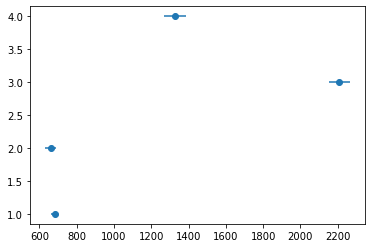

In [107]:
##Q3
## figure1 2009 cool days
confint_bar09 = confint09.reset_index()
fig1, ax1 = plt.subplots(nrows=1, ncols=1)
_ = plt.errorbar(
    x=confint_bar09['theta_cool'], 
    y=confint_bar09['REGIONC'],
    xerr=confint_bar09['cool_se']* 1.96,
    fmt='o'
    )
_ = ax3.set_xlabel('Mean and 95% CI (xx units)')

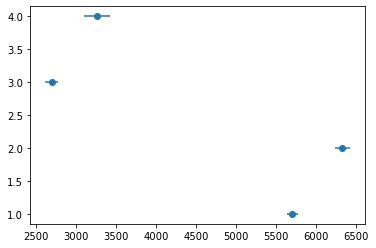

In [108]:
## figure2 2009 heat days
fig2, ax2 = plt.subplots(nrows=1, ncols=1)
_ = plt.errorbar(
    x=confint_bar09['theta_heat'], 
    y=confint_bar09['REGIONC'],
    xerr=confint_bar09['heat_se']* 1.96,
    fmt='o'
    )
_ = ax3.set_xlabel('Mean and 95% CI (xx units)')

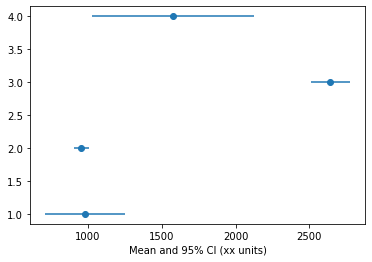

In [103]:
## figure3 2015 cool days
confint_bar15 = confint15.reset_index()
fig3, ax3 = plt.subplots(nrows=1, ncols=1)
_ = plt.errorbar(
    x=confint_bar15['theta_cool'], 
    y=confint_bar15['REGIONC'],
    xerr=confint_bar15['cool_se']* 1.96,
    fmt='o'
    )
_ = ax3.set_xlabel('Mean and 95% CI (xx units)')

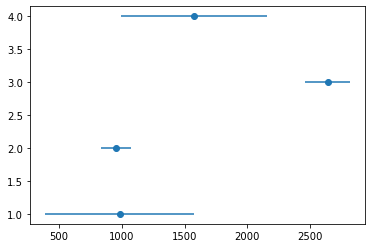

In [105]:
## figure4 2015 heat days
fig4, ax4 = plt.subplots(nrows=1, ncols=1)
_ = plt.errorbar(
    x=confint_bar15['theta_cool'], 
    y=confint_bar15['REGIONC'],
    xerr=confint_bar15['heat_se']* 1.96,
    fmt='o'
    )
_ = ax3.set_xlabel('Mean and 95% CI (xx units)')

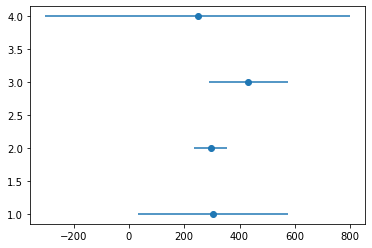

In [116]:
## figure5 variance in cool days
variance_bar = variance.reset_index()
fig5, ax5 = plt.subplots(nrows=1, ncols=1)
_ = plt.errorbar(
    x=variance_bar['cool_change'], 
    y=variance_bar['REGIONC'],
    xerr=variance_bar['new_se_cool']* 1.96,
    fmt='o'
    )
_ = ax3.set_xlabel('Mean and 95% CI (xx units)')

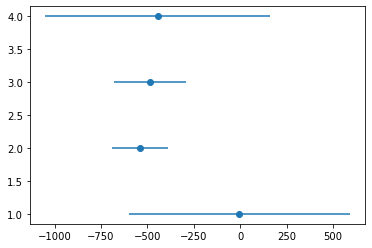

In [117]:
## figure6 variance in heat days
variance_bar = variance.reset_index()
fig6, ax6 = plt.subplots(nrows=1, ncols=1)
_ = plt.errorbar(
    x=variance_bar['heat_change'], 
    y=variance_bar['REGIONC'],
    xerr=variance_bar['new_se_heat']* 1.96,
    fmt='o'
    )
_ = ax3.set_xlabel('Mean and 95% CI (xx units)')